# Face Quality Assessment with MagFace

Import `mlmodule` modules

In [22]:
from mlmodule.torch.options import TorchRunnerOptions
from mlmodule.torch.runners import TorchInferenceRunner
from mlmodule.callbacks.memory import (
    CollectBoundingBoxesInMemory,
    CollectFeaturesInMemory,
)
from mlmodule.torch.datasets import (
    LocalBinaryFilesDataset,
    ImageDataset,
    ImageBoundingBoxDataset,
)
from mlmodule.helpers.files import list_files_in_dir

from mlmodule.models.mtcnn.pretrained import torch_mtcnn
from mlmodule.models.magface.pretrained import torch_magface

import torch
import matplotlib.pyplot as plt
import numpy as np
from facenet_pytorch.models.utils.detect_face import crop_resize
from PIL import Image
import seaborn as sns
sns.set(style="white")
%matplotlib inline


Load images

In [23]:
base_path = "../../tests/fixtures/remi_faces"
file_names = list_files_in_dir(base_path, allowed_extensions=('jpg',))
remi_dataset = ImageDataset(LocalBinaryFilesDataset(file_names))

Run face detection with `torch_mtcnn`

In [24]:
torch_device = "cpu"
face_detector = torch_mtcnn(device=torch_device)

# Callbacks
bb = CollectBoundingBoxesInMemory()

# Runner
runner = TorchInferenceRunner(
    model=face_detector,
    dataset=remi_dataset,
    callbacks=[bb],
    options=TorchRunnerOptions(
        data_loader_options={'batch_size': 1},
        device=torch_device, 
        tqdm_enabled=True
    ),
)
runner.run()


100%|██████████| 11/11 [00:02<00:00,  5.32it/s]


Extract face features with `torch_magface`

In [25]:
magface = torch_magface(device=torch_device)

# Dataset
dataset = ImageBoundingBoxDataset(
    image_dataset=ImageDataset(LocalBinaryFilesDataset(bb.indices)),
    bounding_boxes=bb.bounding_boxes,
)

# Callbacks
ff = CollectFeaturesInMemory()

# Runner
runner = TorchInferenceRunner(
    model=magface,
    dataset=dataset,
    callbacks=[ff],
    options=TorchRunnerOptions(
        data_loader_options={'batch_size': 3},
        device=torch_device, 
        tqdm_enabled=True
    ),
)
runner.run()

100%|██████████| 4/4 [00:01<00:00,  2.36it/s]


Show face quality using feature magnitudes

In [26]:
def image_grid(array, ncols=10):
    index, height, width, channels = array.shape
    nrows = index//ncols

    img_grid = (array.reshape(nrows, ncols, height, width, channels)
                .swapaxes(1, 2)
                .reshape(height*nrows, width*ncols, channels))

    return img_grid

def display_faces_with_magnitude(features, bounding_boxes, ncols=10):
    # compute feature magnitudes
    mags = torch.linalg.norm(torch.tensor(features.features), dim=1)
    sort_idx = torch.argsort(mags)

    img_arr = []
    for k in sort_idx:
        filename, face_index = features.indices[k]
        img = Image.open(filename)
        bbox_index = bounding_boxes.indices.index(filename)
        box = bounding_boxes.bounding_boxes[bbox_index].bounding_boxes[face_index]
        cropped_face = np.asarray(crop_resize(img, box, image_size=112))
        img_arr.append(cropped_face)

    if len(img_arr)%ncols:
        for i in range(len(img_arr), (len(img_arr)//ncols+1)*ncols):
            img_arr.append(255 * np.ones((112, 112, 3), np.uint8))

    result = image_grid(np.array(img_arr), ncols=ncols)
    fig = plt.figure(figsize=(20., 20.))
    plt.imshow(result)
    print('feature magnitude: {}'.format([float('{0:.2f}'.format(mags[idx_].item())) for idx_ in sort_idx]))
    return sort_idx

feature magnitude: [19.81, 22.79, 22.8, 23.64, 23.67, 24.06, 25.81, 26.12, 26.16, 27.21, 28.74]


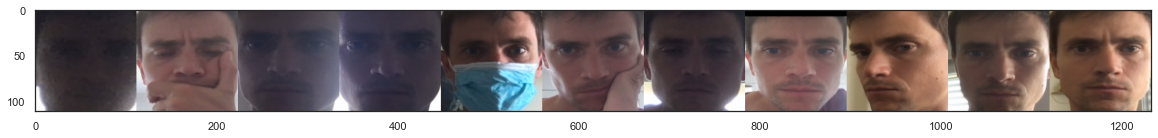

In [27]:
sort_idx = display_faces_with_magnitude(ff, bb, ncols=11)

We can see that there exists a positive correlation between the quality of the faces and the magnitude of the MagFace feature vectors. 

Display face similarity

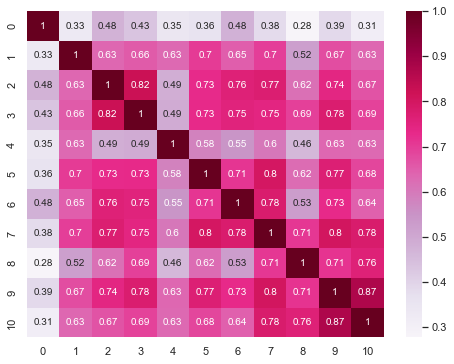

In [28]:
normalized_features = torch.nn.functional.normalize(torch.tensor(ff.features))[sort_idx]
sim_mat = normalized_features @ normalized_features.T
fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.heatmap(sim_mat, cmap="PuRd", annot=True)


As we can see on the heatmap below, face quality strongly affects face recognition performance as the cosine similarities between bad quality faces and high quality faces are much smaller. 